In [1]:
#Modification of https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error

In [3]:
#strip the date format
dateparse = lambda dates: datetime.strptime(dates, '%Y-%m-%d')

#read csv file
stock_pd = pd.read_csv('./dataset/goog.csv',index_col='date',parse_dates=['date'],
                       date_parser=dateparse).fillna(0)

In [4]:
stock_pd


,open,high,low,close,volume,adj_close
date,,,,,,
2014-02-03,1179.20,1212.87,1128.02,1203.79,2409900,1203.79
2014-01-02,1115.46,1186.54,1082.27,1180.97,2860800,1180.97
2013-12-02,1063.51,1121.00,1049.02,1120.71,1675400,1120.71
2013-11-01,1031.79,1068.00,1005.00,1059.59,1372400,1059.59
2013-10-01,880.25,1041.52,842.98,1030.58,2472300,1030.58
...,...,...,...,...,...,...
2006-05-01,418.47,419.44,360.57,371.82,8360000,371.82
2006-04-03,389.53,450.72,387.93,417.94,10143900,417.94
2006-03-01,368.56,399.00,331.55,390.00,14925400,390.00


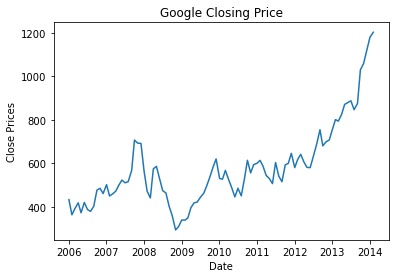

In [5]:
#Visualise stock closing

plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_pd['close'])
plt.title('Google Closing Price')
plt.show()

<AxesSubplot:ylabel='Density'>

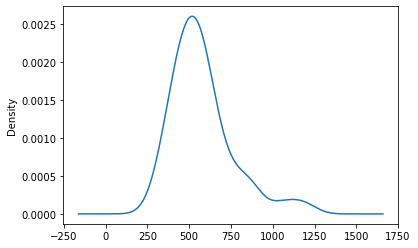

In [8]:
#Visualise distribution
#Check the trend,seasonality etc
close =stock_pd['close']
close.plot.kde()

In [6]:
#Function to test if the data is stationary
def stationary_series(timeseries):
    #12 refers to 12 months
    rollingmean=timeseries.rolling(12).mean()
    rollingstd=timeseries.rolling(12).std()
    
    #Plot
    plt.plot(timeseries,color='black',label="Original")
    plt.plot(rollingmean,color="red", label="Rolling mean")
    plt.plot(rollingstd,color="green",label="Rolling standard deviation")
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print('Results of ADF')
    adft=adfuller(timeseries,autolag="AIC")
    output = pd.Series(adft[0:4],index=['test Statistics','p-value','No. of lags','No of observations used'])
    
    for key,values in adft[4].items():
        output['critical value (%s)'%key]=values
    print(output)

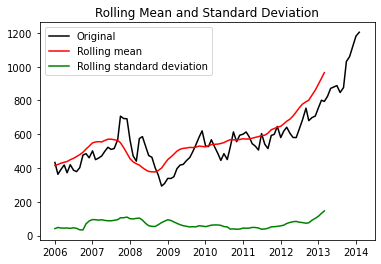

Results of ADF
test Statistics            -3.597295
p-value                     0.005813
No. of lags                 0.000000
No of observations used    97.000000
critical value (1%)        -3.499637
critical value (5%)        -2.891831
critical value (10%)       -2.582928
dtype: float64


In [9]:
#Call function to check if data is stationary
stationary_series(close)

#Data is stationary as the p-value is rejected. 
#Test Statistics is more extreme than critical value. (Null hypothesis is rejected)

In [10]:
#Log values
stock_log=np.log(close)

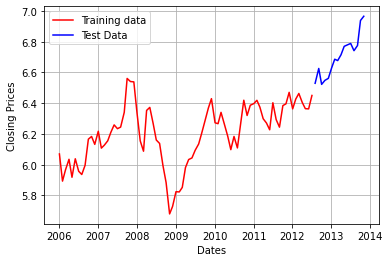

In [11]:
#Split to train and validation. 
#The data is such that the first few values are the lastest dates.
test,train=stock_log[3:int(len(stock_log)*0.2)],stock_log[int(len(stock_log)*0.2):]

plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train,'red',label="Training data")
plt.plot(test,"blue",label="Test Data")
plt.legend()



Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-138.369, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-136.571, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-136.627, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-140.172, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-135.572, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.265 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  71.086
Date:                Fri, 17 May 2024   AIC                           -140.172
Time:                        14:16:42   BIC                           -137.816
Sample:                             0   HQIC                          -139.229
                                 - 79                                       

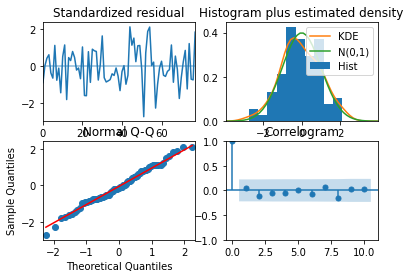

In [12]:
#Select best model (best arima parameters)

model_arima = auto_arima(train,start_p=0,start_q=0,test='adf',
                         max_p=3,max_q=3, m=1, d=None,start_P=0,D=0, trace=True,
                         error_action='ignore',supress_warnings=True,stepwise=True)

print(model_arima.summary())

model_arima.plot_diagnostics()
plt.show()

In [13]:
#get prediction for each data point
predictions=list()
history = [ x for x in train]

for x in range(len(test)):
    # Forecast
    model = ARIMA(history,order=(0,1,0))
    model_fit =model.fit()
    print(model_fit.summary())
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(test[x])
    print('predicted=%f, expected=%f' % (output[0],test[x]))
    
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   79
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  71.086
Date:                Fri, 17 May 2024   AIC                           -140.172
Time:                        14:17:23   BIC                           -137.816
Sample:                             0   HQIC                          -139.229
                                 - 79                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0095      0.002      5.965      0.000       0.006       0.013
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 0.12
Prob(Q):                              0.65   Pr

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   91
Model:                 ARIMA(0, 1, 0)   Log Likelihood                  54.111
Date:                Fri, 17 May 2024   AIC                           -106.221
Time:                        14:17:23   BIC                           -103.722
Sample:                             0   HQIC                          -105.213
                                 - 91                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0176      0.001     22.671      0.000       0.016       0.019
Ljung-Box (L1) (Q):                   1.28   Jarque-Bera (JB):              1774.78
Prob(Q):                              0.26   Pr

In [14]:
#combining the predicted and actuals
result_df= test.reset_index()
result_df["pred"]=predictions
result_df = result_df.set_index("date")

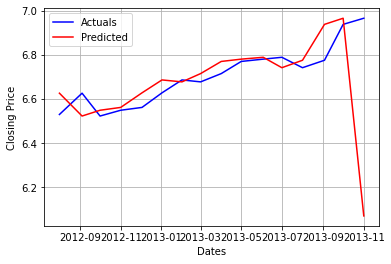

In [15]:
# plot forecasts against actual outcomes
plt.grid(True)
plt.xlabel("Dates")
plt.ylabel("Closing Price")
plt.plot(result_df["close"],color="blue",label="Actuals")
plt.plot(result_df['pred'], color='red',label="Predicted")
plt.legend()

plt.show()